Random Forest Cross-validation scores: [0.99722313 0.99673309 0.99697811 0.99632473 0.99705978]
Mean CV accuracy: 0.9968637700098008
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7645
           1       1.00      1.00      1.00      7661

    accuracy                           1.00     15306
   macro avg       1.00      1.00      1.00     15306
weighted avg       1.00      1.00      1.00     15306

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7645
           1       0.99      1.00      1.00      7661

    accuracy                           1.00     15306
   macro avg       1.00      1.00      1.00     15306
weighted avg       1.00      1.00      1.00     15306

Random Forest Accuracy

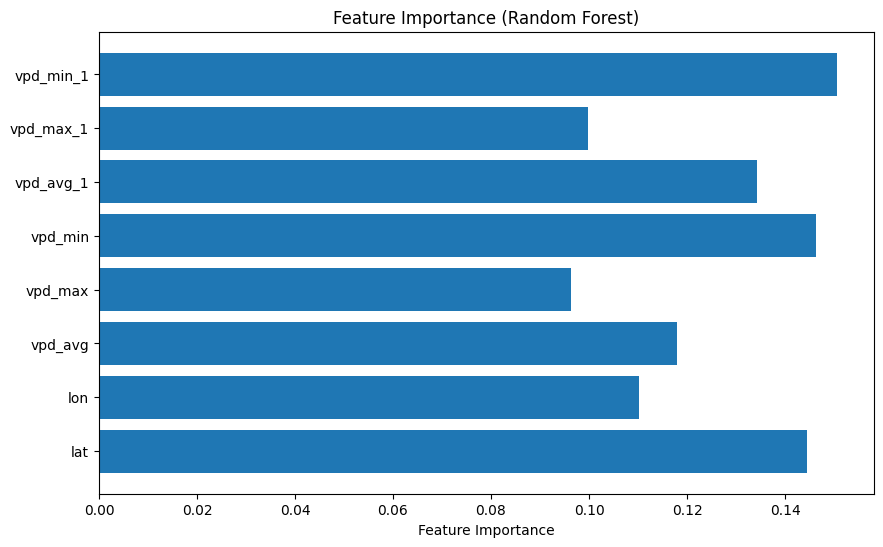

<Figure size 1000x600 with 0 Axes>

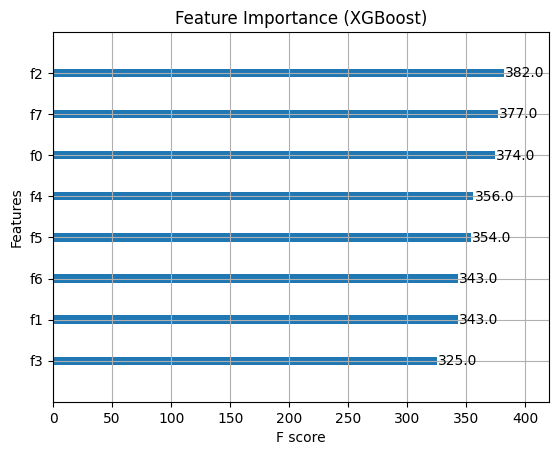

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Step 1: Load the data (assuming you have your dataset in CSV format)
# Replace 'forest_fire_data.csv' with the path to your dataset
df = pd.read_csv('2021.csv')

# Step 2: Generate synthetic data (non-fire instances)
# For simplicity, we assume the synthetic data is randomly sampled within the range of existing values in the dataset

# Create synthetic non-fire samples by random sampling from the dataset
num_non_fire_samples = len(df)  # Create the same number of non-fire instances as fire instances

# Randomly sample the features to create non-fire samples
lat_min, lat_max = df['lat'].min(), df['lat'].max()
lon_min, lon_max = df['lon'].min(), df['lon'].max()

synthetic_data = {
    'lat': np.random.uniform(lat_min, lat_max, num_non_fire_samples),
    'lon': np.random.uniform(lon_min, lon_max, num_non_fire_samples),
    'vpd_avg': np.random.uniform(df['vpd_avg'].min(), df['vpd_avg'].max(), num_non_fire_samples),
    'vpd_max': np.random.uniform(df['vpd_max'].min(), df['vpd_max'].max(), num_non_fire_samples),
    'vpd_min': np.random.uniform(df['vpd_min'].min(), df['vpd_min'].max(), num_non_fire_samples),
    'vpd_avg_1': np.random.uniform(df['vpd_avg_1'].min(), df['vpd_avg_1'].max(), num_non_fire_samples),
    'vpd_max_1': np.random.uniform(df['vpd_max_1'].min(), df['vpd_max_1'].max(), num_non_fire_samples),
    'vpd_min_1': np.random.uniform(df['vpd_min_1'].min(), df['vpd_min_1'].max(), num_non_fire_samples)
}

# Create DataFrame for synthetic data and add a label (0 for no fire)
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df['Label'] = 0  # Label for no fire

# Step 3: Combine the fire data with the synthetic non-fire data
df['Label'] = 1  # Label for fire data
combined_df = pd.concat([df, synthetic_df], axis=0).reset_index(drop=True)

# Step 4: Data Preprocessing
# Features (latitude, longitude, VPD values)
X = combined_df[['lat', 'lon', 'vpd_avg', 'vpd_max', 'vpd_min', 'vpd_avg_1', 'vpd_max_1', 'vpd_min_1']].values
y = combined_df['Label'].values

# Use SMOTE to handle imbalanced dataset by oversampling the minority class (non-fire)
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Step 5: Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Feature Scaling (important for ensemble models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Cross-Validation
# Perform cross-validation to evaluate model performance
rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, scoring='accuracy')
print("Random Forest Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

# Step 7: Hyperparameter Tuning using GridSearchCV (Random Forest)
# Define the parameter grid for Random Forest
param_grid_rfc = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rfc, cv=3, scoring='accuracy')
grid_search_rfc.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rfc.best_params_)

# Step 8: Train the best model (Random Forest)
best_rfc = grid_search_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

# Step 9: XGBoost (Ensemble Method) Implementation
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y_train) / np.sum(y_train), random_state=42)
xgb_model.fit(X_train, y_train)

# Step 10: Predictions and Model Evaluation
# Predictions with Random Forest
y_pred_rfc = best_rfc.predict(X_test)

# Predictions with XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Classification Report (Random Forest)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc))

# Classification Report (XGBoost)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Accuracy Scores
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rfc))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# ROC-AUC Score (for both models)
roc_auc_rfc = roc_auc_score(y_test, best_rfc.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])

print("Random Forest ROC-AUC Score:", roc_auc_rfc)
print("XGBoost ROC-AUC Score:", roc_auc_xgb)

# Step 11: Feature Importance (Random Forest and XGBoost)
# Feature Importance for Random Forest
feature_importances_rfc = best_rfc.feature_importances_
feature_names = ['lat', 'lon', 'vpd_avg', 'vpd_max', 'vpd_min', 'vpd_avg_1', 'vpd_max_1', 'vpd_min_1']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances_rfc)
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

# Feature Importance for XGBoost
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model)
plt.title('Feature Importance (XGBoost)')
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7645
           1       1.00      1.00      1.00      7661

    accuracy                           1.00     15306
   macro avg       1.00      1.00      1.00     15306
weighted avg       1.00      1.00      1.00     15306

Accuracy Score: 0.9973866457598327
ROC-AUC Score: 0.9999655616015785


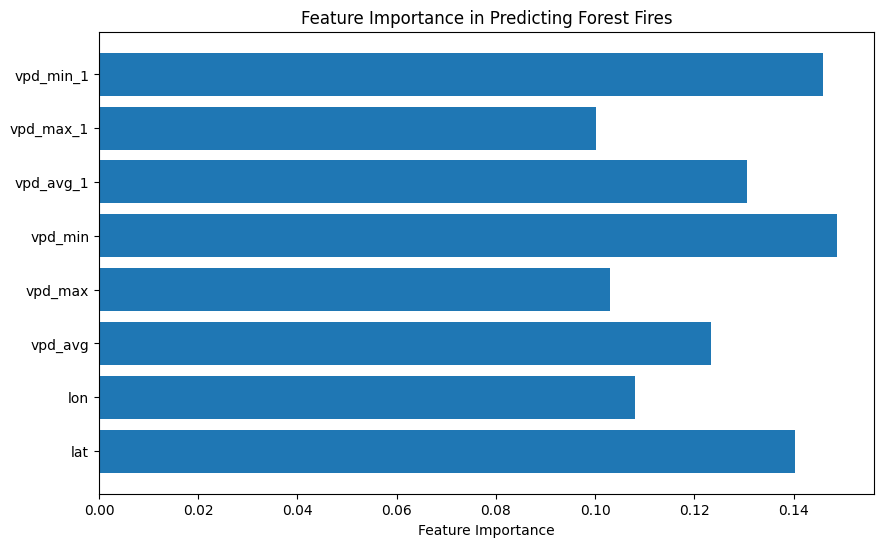

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Step 1: Load the data (assuming you have your dataset in CSV format)
# Replace 'forest_fire_data.csv' with the path to your dataset
df = pd.read_csv('2021.csv')

# Step 2: Generate synthetic data (non-fire instances)
# For simplicity, we assume the synthetic data is randomly sampled within the range of existing values in the dataset

# Create synthetic non-fire samples by random sampling from the dataset
num_non_fire_samples = len(df)  # Create the same number of non-fire instances as fire instances

# Randomly sample the features to create non-fire samples
lat_min, lat_max = df['lat'].min(), df['lat'].max()
lon_min, lon_max = df['lon'].min(), df['lon'].max()

synthetic_data = {
    'lat': np.random.uniform(lat_min, lat_max, num_non_fire_samples),
    'lon': np.random.uniform(lon_min, lon_max, num_non_fire_samples),
    'vpd_avg': np.random.uniform(df['vpd_avg'].min(), df['vpd_avg'].max(), num_non_fire_samples),
    'vpd_max': np.random.uniform(df['vpd_max'].min(), df['vpd_max'].max(), num_non_fire_samples),
    'vpd_min': np.random.uniform(df['vpd_min'].min(), df['vpd_min'].max(), num_non_fire_samples),
    'vpd_avg_1': np.random.uniform(df['vpd_avg_1'].min(), df['vpd_avg_1'].max(), num_non_fire_samples),
    'vpd_max_1': np.random.uniform(df['vpd_max_1'].min(), df['vpd_max_1'].max(), num_non_fire_samples),
    'vpd_min_1': np.random.uniform(df['vpd_min_1'].min(), df['vpd_min_1'].max(), num_non_fire_samples)
}

# Create DataFrame for synthetic data and add a label (0 for no fire)
synthetic_df = pd.DataFrame(synthetic_data)
synthetic_df['Label'] = 0  # Label for no fire

# Step 3: Combine the fire data with the synthetic non-fire data
df['Label'] = 1  # Label for fire data
combined_df = pd.concat([df, synthetic_df], axis=0).reset_index(drop=True)

# Step 4: Data Preprocessing
# Features (latitude, longitude, VPD values)
X = combined_df[['lat', 'lon', 'vpd_avg', 'vpd_max', 'vpd_min', 'vpd_avg_1', 'vpd_max_1', 'vpd_min_1']].values
y = combined_df['Label'].values

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling (important for Random Forest)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Train the Random Forest Classifier (RFC)
rfc = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

rfc.fit(X_train, y_train)

# Step 6: Predictions and Model Evaluation
y_pred = rfc.predict(X_test)

# Evaluate the model using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy Score:", accuracy_score(y_test, y_pred))

# ROC-AUC Score (important for imbalanced datasets)
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print("ROC-AUC Score:", roc_auc)

# Step 7: Feature Importance (Optional)
# Random Forest allows us to see which features are most important in the prediction
feature_importances = rfc.feature_importances_
feature_names = ['lat', 'lon', 'vpd_avg', 'vpd_max', 'vpd_min', 'vpd_avg_1', 'vpd_max_1', 'vpd_min_1']

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Predicting Forest Fires')
plt.show()


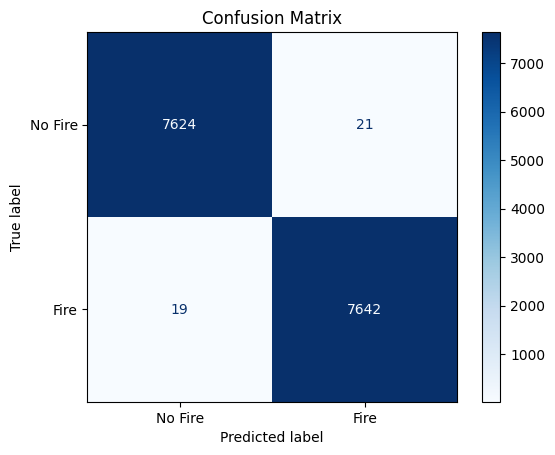

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
